In [ ]:
!gdown 1vRu3Pj2zYM_NL8xOheerI7wMgmAokdGv # grab latest merged file

Downloading...
From: https://drive.google.com/uc?id=1vRu3Pj2zYM_NL8xOheerI7wMgmAokdGv
To: /content/MAIN_ANNOTATIONS_MERGED.tsv
100% 906k/906k [00:00<00:00, 9.51MB/s]


In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import LinearSegmentedColormap
# from matplotlib.gridspec import GridSpec
# from matplotlib.patches import Rectangle

# # Download and load Times New Roman (regular and bold) for Google Colab
# import matplotlib as mpl
# import matplotlib.font_manager as fm
# import subprocess
# import os

# # Download Times New Roman regular and bold if not already present
# if not os.path.exists('/content/TimesNewRoman.ttf'):
#     subprocess.run(['wget', '-O', '/content/TimesNewRoman.ttf',
#                    'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf'],
#                    capture_output=True)

# if not os.path.exists('/content/TimesNewRomanBold.ttf'):
#     subprocess.run(['wget', '-O', '/content/TimesNewRomanBold.ttf',
#                    'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Bold.ttf'],
#                    capture_output=True)

# # Load both fonts
# font_dirs = ["/content/"]
# font_files = fm.findSystemFonts(fontpaths=font_dirs, fontext='ttf')
# for font_file in font_files:
#     if 'TimesNewRoman' in font_file:
#         fm.fontManager.addfont(font_file)
#         print(f"Loaded font: {font_file}")

# # Clear matplotlib font cache to recognize new font
# plt.rcParams['font.family'] = 'serif'  # Reset first
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# plt.rcParams.update({
#     "figure.dpi": 300,
#     "savefig.dpi": 300,
#     "font.size": 15,
#     "axes.titlesize": 20,
#     "axes.labelsize": 15,
#     "xtick.labelsize": 13,
#     "ytick.labelsize": 13,
#     "legend.fontsize": 16,
#     "axes.spines.top": False,
#     "axes.spines.right": False,
#     "axes.titlepad": 6,
#     "font.family": "Times New Roman",
#     "mathtext.fontset": "custom",
#     "mathtext.rm": "Times New Roman",
#     "mathtext.it": "Times New Roman:italic",
#     "mathtext.bf": "Times New Roman:bold",
# })

# # Category labels
# CATEGORY_SHORT = {
#     1: "Bias\n& Harm",
#     2: "Sensitive\nContent",
#     3: "Performance\nDisparity",
#     4: "Env. Costs\n& Emissions",
#     5: "Privacy\n& Data",
#     6: "Financial\nCosts",
#     7: "Moderation\nLabor"
# }

# # Scaling parameters
# MIN_RECT_HEIGHT = 0.15  # Minimum rectangle height (in axis units)
# MAX_RECT_HEIGHT = 0.8   # Maximum rectangle height (in axis units)
# RECT_WIDTH = 0.4        # Fixed rectangle width (in axis units)
# POWER_SCALE = 0.65

# # Power scaling function for rectangle heights
# def _height_for_count_power_scaled(count_val, min_count, max_count, min_height, max_height, power=POWER_SCALE):
#     if count_val == 0:
#         return 0

#     power_count_val = np.power(count_val, power)
#     power_min_count = np.power(min_count, power)
#     power_max_count = np.power(max_count, power)

#     if power_max_count <= power_min_count:
#         return min_height if count_val > 0 else 0

#     scaled_height = (power_count_val - power_min_count) / \
#                    (power_max_count - power_min_count) * \
#                    (max_height - min_height) + min_height
#     return max(min_height, scaled_height)

# # Color setup
# norm = plt.Normalize(vmin=0.0, vmax=3.0)
# colors = ['#F0F8FF', '#B0E0E6', '#87CEEB', '#4682B4', '#191970', '#000080']
# cmap = LinearSegmentedColormap.from_list('blue_gradient', colors, N=256)

# # Weighted average function
# def weighted_avg_func(group):
#     if group["model_eval_count"].sum() == 0:
#         return group["model_avg_score"].mean()
#     return np.average(group["model_avg_score"], weights=group["model_eval_count"])

# # Category order and mapping
# order_cats = list(range(1, 8))
# x_map = {cat: i for i, cat in enumerate(order_cats)}

# def create_rectangle_plot(group_key, title=None, y_label=None, fig_width=12, fig_height=None, row_gap=0.8,
#                          show_size_legend=True, legend_width_ratio=1.5,
#                          data_path="MAIN_ANNOTATIONS_MERGED.tsv",
#                          min_rect_height=0.2, max_rect_height=0.6, rect_width=0.7,
#                          power_scale=0.65,
#                          plot_margins={'top': 0.95, 'bottom': 0.12, 'left': 0.15, 'right': 0.99},
#                          wspace=0.05, aspect_ratio=None, provider_list=None,
#                          show_quality_scores=True, num_legend_items=4):
#     """
#     Create a rectangle plot for any grouping key from the master data file.
#     Uses rectangles where height represents count and color/numbers show average quality scores.

#     Parameters:
#     -----------
#     group_key : str
#         Column name to group by (e.g., 'openness', 'country', 'provider', 'sector')
#     title : str, optional
#         Plot title. If None, will be auto-generated.
#     y_label : str, optional
#         Y-axis label. If None, will use group_key with proper formatting.
#     fig_width : float, optional
#         Figure width in inches (default: 12).
#     fig_height : float, optional
#         Figure height in inches. If None, calculated automatically based on number of rows (default: None)
#     row_gap : float, optional
#         Vertical spacing between rows in the plot (default: 0.8).
#     show_size_legend : bool, optional
#         Whether to show a size scale legend on the right (default: True).
#     legend_width_ratio : float, optional
#         Relative width for the legend area when shown (default: 1.5).
#     data_path : str, optional
#         Path to the master data file (default: "MAIN_ANNOTATIONS_MERGED.tsv")
#     min_rect_height : float, optional
#         Minimum height for rectangles in axis units (default: 0.2)
#     max_rect_height : float, optional
#         Maximum height for rectangles in axis units (default: 0.6)
#     rect_width : float, optional
#         Fixed width for rectangles in axis units (default: 0.7)
#     power_scale : float, optional
#         Power scaling factor (0.5=gentle, 0.65=moderate, 0.8=mild, 1.0=linear) (default: 0.65)
#     plot_margins : dict, optional
#         Plot margins as fractions {'top': val, 'bottom': val, 'left': val, 'right': val}
#     wspace : float, optional
#         Horizontal spacing between main plot and legend subplots (default: 0.3)
#     aspect_ratio : float, optional
#         Force a specific aspect ratio for the main plot area. If None, uses natural aspect.
#     provider_list : list of str, optional
#         A list of provider names to include in the plot if `group_key` is 'provider'.
#     show_quality_scores : bool, optional
#         Whether to show average quality scores inside rectangles (default: True).
#     num_legend_items : int, optional
#         Number of items to show in the size scale legend (default: 4).

#     Returns:
#     --------
#     fig : matplotlib.figure.Figure
#         The created figure object
#     """

#     # Load data
#     try:
#         data_df = pd.read_csv(data_path, sep="\t")
#         data_df.columns = [c.strip() for c in data_df.columns]
#     except Exception as e:
#         raise Exception(f"Error loading data file: {e}")

#     # Validate inputs
#     required_cols = {"provider", "name", "category", "score", group_key}
#     missing = required_cols - set(data_df.columns)
#     if missing:
#         raise ValueError(f"Missing required columns: {missing}")

#     # Check if group_key exists and has data
#     if data_df[group_key].isna().all():
#         raise ValueError(f"All values in '{group_key}' are NaN")

#     # Auto-generate labels if not provided
#     if title is None:
#         title = f"Evaluations by {group_key.replace('_', ' ').title()}"

#     if y_label is None:
#         y_label = group_key.replace('_', ' ').title()

#     # Clean and filter data
#     df_clean = data_df.copy()
#     df_clean["category"] = pd.to_numeric(df_clean["category"], errors="coerce").astype("Int64")
#     df_clean["score"] = pd.to_numeric(df_clean["score"], errors="coerce")

#     df_clean = df_clean[
#         df_clean["category"].isin(range(1, 8)) &
#         df_clean["score"].between(0, 3, inclusive="both") &
#         df_clean[group_key].notna()
#     ].copy()

#     if group_key == 'provider' and provider_list is not None:
#         provider_set = set(str(p) for p in provider_list)
#         df_clean = df_clean[df_clean[group_key].astype(str).isin(provider_set)].copy()
#         if df_clean.empty:
#             raise ValueError(f"No data remaining after filtering for the provided provider_list: {provider_list}")

#     if len(df_clean) == 0:
#         raise ValueError(f"No valid data remaining after filtering for group_key '{group_key}'")

#     # Aggregate data
#     base_model_cat_identifiers = ["provider", "name", "category"]
#     final_groupby_cols_for_model_cat = list(base_model_cat_identifiers)
#     if group_key not in final_groupby_cols_for_model_cat:
#         final_groupby_cols_for_model_cat.append(group_key)

#     model_cat = (
#         df_clean.groupby(final_groupby_cols_for_model_cat, dropna=True)
#         .agg(model_eval_count=("score", "size"),
#              model_avg_score=("score", "mean"))
#         .reset_index()
#     )

#     model_cat = model_cat[model_cat[group_key].notna()].copy()

#     if len(model_cat) == 0:
#         raise ValueError(f"No data remaining after aggregation for group_key '{group_key}'")

#     if group_key == 'provider' and provider_list is not None:
#         actual_providers_in_data = model_cat[group_key].dropna().astype(str).unique().tolist()
#         final_order = [p for p in provider_list if str(p) in actual_providers_in_data]
#         if not final_order:
#             raise ValueError(f"None of the providers in the provided `provider_list` ({provider_list}) were found in the data for group_key '{group_key}' after initial filtering.")
#     else:
#         group_options = model_cat[group_key].dropna().astype(str).unique().tolist()
#         final_order = sorted(group_options)

#     num_rows = len(final_order)

#     if num_rows == 0:
#         raise ValueError(f"No valid groups found for group_key '{group_key}'")

#     # Calculate dynamic figure height if not provided
#     if fig_height is None:
#         plot_area_height = (num_rows - 1) * row_gap + 1.5
#         fig_height = max(4, plot_area_height * 0.8)  # Cap minimum height, scale down

#     # Create figure with or without legend
#     if show_size_legend:
#         fig = plt.figure(figsize=(fig_width, fig_height))
#         gs = GridSpec(1, 2, figure=fig,
#                       width_ratios=[10, legend_width_ratio],
#                       wspace=wspace,
#                       top=plot_margins['top'], bottom=plot_margins['bottom'],
#                       left=plot_margins['left'], right=plot_margins['right'])

#         ax_main = fig.add_subplot(gs[0, 0])
#         size_legend_ax = fig.add_subplot(gs[0, 1])
#     else:
#         fig = plt.figure(figsize=(fig_width, fig_height))

#         # Validate margins to prevent matplotlib errors
#         if plot_margins['left'] >= plot_margins['right']:
#             raise ValueError(f"Left margin ({plot_margins['left']}) must be less than right margin ({plot_margins['right']})")
#         if plot_margins['bottom'] >= plot_margins['top']:
#             raise ValueError(f"Bottom margin ({plot_margins['bottom']}) must be less than top margin ({plot_margins['top']})")

#         # Apply margins to the figure
#         fig.subplots_adjust(top=plot_margins['top'], bottom=plot_margins['bottom'],
#                            left=plot_margins['left'], right=plot_margins['right'])

#         ax_main = fig.add_subplot(111)
#         size_legend_ax = None

#     ax_main.tick_params(axis='x', pad=5)

#     # Data aggregation
#     grouping_cols_for_agg = [group_key, "category"]

#     prov_cat_counts = (
#         model_cat.groupby(grouping_cols_for_agg, dropna=True)["model_eval_count"]
#         .sum().rename("count").reset_index()
#     )

#     prov_cat_quality_weighted = (
#         model_cat.groupby(grouping_cols_for_agg, dropna=True, group_keys=False)
#         .apply(weighted_avg_func, include_groups=False)
#         .rename("avg_score").reset_index()
#     )

#     plot_data = prov_cat_counts.merge(prov_cat_quality_weighted,
#                                      on=grouping_cols_for_agg, how="inner")

#     plot_data = plot_data[plot_data[group_key].notna()].copy()
#     plot_data[group_key] = plot_data[group_key].astype(str)
#     plot_data[group_key] = pd.Categorical(plot_data[group_key], categories=final_order, ordered=True)
#     plot_data["category"] = pd.Categorical(plot_data["category"], categories=order_cats, ordered=True)
#     plot_data = plot_data.sort_values([group_key, "category"]).reset_index(drop=True)

#     y_map = {str(item): i * row_gap for i, item in enumerate(final_order)}
#     x = plot_data["category"].map(lambda c: x_map[int(c)])
#     y = plot_data[group_key].map(lambda p: y_map[str(p)])

#     # Calculate rectangle heights
#     local_counts = plot_data[plot_data["count"] > 0]["count"]
#     local_min_val = 1
#     local_max_val = local_counts.max() if not local_counts.empty else 1
#     if local_max_val < local_min_val:
#         local_max_val = local_min_val

#     heights = np.zeros_like(plot_data["count"].values, dtype=float)
#     mask = plot_data["count"] > 0

#     heights[mask] = [
#         _height_for_count_power_scaled(c, local_min_val, local_max_val, min_rect_height, max_rect_height, power_scale)
#         for c in plot_data["count"][mask].astype(float)
#     ]

#     # Plot rectangles
#     if mask.any():
#         for i in np.where(mask)[0]:
#             x_pos = x.iloc[i]
#             y_pos = y.iloc[i]
#             height = heights[i]
#             color = cmap(norm(plot_data["avg_score"].iloc[i]))
#             avg_score = plot_data["avg_score"].iloc[i]

#             # Create rectangle centered at (x_pos, y_pos)
#             rect = Rectangle((x_pos - rect_width/2, y_pos - height/2),
#                            rect_width, height,
#                            facecolor=color, edgecolor='k', linewidth=0.8, alpha=0.7, zorder=2)
#             ax_main.add_patch(rect)

#             # Add quality score inside rectangle if enabled
#             if show_quality_scores and not np.isnan(avg_score):
#                 # Choose text color based on background color brightness
#                 text_color = 'white' if np.mean(color[:3]) < 0.5 else 'black'
#                 ax_main.text(x_pos, y_pos, f'{avg_score:.1f}',
#                            ha='center', va='center', fontsize=9, fontweight='bold',
#                            color=text_color, zorder=3)

#     # Set up axes
#     ax_main.set_xticks(range(len(order_cats)))
#     ax_main.set_xticklabels([CATEGORY_SHORT[c] for c in order_cats], fontweight='bold')

#     y_positions = [i * row_gap for i in range(len(final_order))]
#     ax_main.set_yticks(y_positions)

#     # Function to wrap long labels with newlines
#     def wrap_label(label, max_chars=15):
#         words = str(label).replace('_', ' ').split()
#         wrapped_words = []
#         current_line = []
#         current_length = 0

#         for word in words:
#             word = word.capitalize()
#             # If adding this word would exceed max_chars, start a new line
#             if current_length + len(word) + (1 if current_line else 0) > max_chars:
#                 if current_line:  # Only if we have words in current line
#                     wrapped_words.append(' '.join(current_line))
#                     current_line = [word]
#                     current_length = len(word)
#                 else:  # Word itself is too long, just add it
#                     wrapped_words.append(word)
#                     current_length = 0
#             else:
#                 current_line.append(word)
#                 current_length += len(word) + (1 if len(current_line) > 1 else 0)

#         if current_line:
#             wrapped_words.append(' '.join(current_line))

#         return '\n'.join(wrapped_words)

#     wrapped_labels = []
#     for label in final_order:
#         # First, capitalize the first letter of the entire label
#         processed_label = label.capitalize()

#         # Next, check if the label ends with 'ai' (case-insensitive)
#         if processed_label.lower().endswith('ai'):
#             # If it does, slice off the last two characters and append 'AI'
#             processed_label = processed_label[:-2] + 'AI'

#         # Finally, apply text wrapping and add to the list
#         wrapped_labels.append(textwrap.fill(processed_label, width=y_label_wrap_width))

#     ax_main.set_yticklabels(wrapped_labels, fontweight='bold')

#     ax_main.set_xlim(-0.5, len(order_cats)-0.5)
#     ax_main.set_ylim(-0.5 * row_gap, (len(final_order) - 0.5) * row_gap)
#     ax_main.invert_yaxis()

#     if aspect_ratio is not None:
#         ax_main.set_aspect(aspect_ratio)

#     ax_main.grid(True, which="both", axis="both", linestyle="-", linewidth=0.6, alpha=0.3, zorder=1)

#     ax_main.set_title(title, fontsize=plt.rcParams["axes.titlesize"], pad=plt.rcParams["axes.titlepad"], fontweight='bold')
#     # Removed x-axis label

#     # Create Size Scale Legend (if enabled) - FIXED VERSION
#     if show_size_legend and size_legend_ax is not None:
#         size_legend_ax.axis('off')

#         # Generate legend values - use actual count values starting from 1
#         max_count = int(local_max_val)
#         min_count = 1

#         # Debug output
#         print(f"Legend scaling: max_count = {max_count}, min_count = {min_count}")

#         # Create a reasonable set of count values for the legend, always starting with 1
#         if max_count <= 10:
#             steps_to_show = [1] + list(range(2, max_count + 1, 2)) + [max_count] if max_count > 1 else [1]
#         elif max_count <= 50:
#             steps_to_show = [1, 10, 25, max_count] if max_count > 25 else [1, 10, max_count]
#         elif max_count <= 200:
#             steps_to_show = [1, 25, 75, 150, max_count] if max_count > 150 else [1, 25, 75, max_count]
#         else:
#             # For very large counts
#             steps_to_show = [1, 50, 200, 500, max_count] if max_count > 500 else [1, 50, 200, max_count]

#         # Remove duplicates and sort, always keeping 1 as the first item
#         steps_to_show = sorted(list(set(steps_to_show)))

#         # Limit to num_legend_items, but always keep 1 and max_count
#         if len(steps_to_show) > num_legend_items:
#             # Always include 1 and max
#             selected = [1, max_count]

#             # Add intermediate values
#             remaining_slots = num_legend_items - 2
#             if remaining_slots > 0:
#                 intermediate = [x for x in steps_to_show if x != 1 and x != max_count]
#                 if len(intermediate) <= remaining_slots:
#                     selected.extend(intermediate)
#                 else:
#                     # Select evenly spaced intermediate values
#                     indices = np.linspace(0, len(intermediate) - 1, remaining_slots).astype(int)
#                     selected.extend([intermediate[i] for i in indices])

#             steps_to_show = sorted(list(set(selected)))

#         print(f"Legend steps: {steps_to_show}")

#         # Create size scale visualization as a single vertical line
#         x_center = 0.3

#         # The line height should match the tallest rectangle in the main plot
#         max_rect_height_actual = _height_for_count_power_scaled(local_max_val, local_min_val, local_max_val,
#                                                                min_rect_height, max_rect_height, power_scale)

#         print(f"Max rectangle height (data coords): {max_rect_height_actual}")
#         print(f"Row gap: {row_gap}")
#         print(f"Number of rows: {num_rows}")

#         # Calculate the main plot's total height in data coordinates
#         main_plot_height = (num_rows - 0.5) * row_gap  # Approximate total height of main plot

#         # Scale the legend line to be proportional to the rectangle height relative to plot height
#         # This ensures the legend line visually matches the tallest rectangle
#         height_proportion = max_rect_height_actual / main_plot_height
#         scaled_line_height = height_proportion * 0.8  # Use 80% of legend area for the full line

#         print(f"Main plot height: {main_plot_height}")
#         print(f"Height proportion: {height_proportion}")
#         print(f"Scaled legend line height: {scaled_line_height}")

#         # Position the line centered vertically
#         y_center_legend = 0.5
#         line_bottom = y_center_legend - scaled_line_height / 2
#         line_top = y_center_legend + scaled_line_height / 2

#         # Title
#         size_legend_ax.text(x_center, line_top + 0.15, "Number of\nEvaluations",
#                             transform=size_legend_ax.transAxes,
#                             ha='center', va='bottom', fontsize=10, fontweight='bold')

#         # Draw the main vertical line (height of tallest rectangle)
#         size_legend_ax.plot([x_center, x_center], [line_bottom, line_top],
#                            transform=size_legend_ax.transAxes,
#                            color='black', linewidth=2, zorder=1)

#         # Add tick marks at positions corresponding to actual rectangle heights
#         for count_val in steps_to_show:
#             # Calculate where this count value should appear on the line
#             actual_height = _height_for_count_power_scaled(count_val, local_min_val, local_max_val,
#                                                           min_rect_height, max_rect_height, power_scale)

#             # Position on the line: bottom + (height_ratio * total_line_height)
#             height_ratio = actual_height / max_rect_height_actual
#             y_pos = line_bottom + (height_ratio * scaled_line_height)

#             print(f"Count {count_val}: height = {actual_height}, ratio = {height_ratio}, y_pos = {y_pos}")

#             # Draw tick mark
#             tick_length = 0.04
#             size_legend_ax.plot([x_center - tick_length, x_center + tick_length], [y_pos, y_pos],
#                                transform=size_legend_ax.transAxes,
#                                color='black', linewidth=1.5, zorder=2)

#             # Add number label
#             size_legend_ax.text(x_center + tick_length + 0.05, y_pos,
#                                str(int(count_val)),
#                                transform=size_legend_ax.transAxes,
#                                ha='left', va='center', fontsize=9, fontweight='bold')

#     return fig

In [ ]:
import pandas as pd
import os

# --- Configuration ---
GROUP_KEY_COLUMN = 'region'
data_path = "MAIN_ANNOTATIONS_MERGED.tsv"

# The value we want to check (now in lowercase to match the new logic)
group_value_to_check = "middle east and north africa"
category_to_check = 7

# --- Robust Verification Script ---
try:
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data file not found at: '{data_path}'")

    data_df = pd.read_csv(data_path, sep="\t")
    data_df.columns = [c.strip() for c in data_df.columns]

    if GROUP_KEY_COLUMN not in data_df.columns:
        raise ValueError(f"Error: Column '{GROUP_KEY_COLUMN}' not found.")

    # --- NEW: Print all unique region names to see what's in the data ---
    print("--- Unique values found in the 'region' column ---")
    unique_regions = data_df[GROUP_KEY_COLUMN].dropna().unique()
    print(unique_regions)
    print("-" * 50 + "\n")
    # --------------------------------------------------------------------

    df_check = data_df.copy()
    df_check["category"] = pd.to_numeric(df_check["category"], errors="coerce")
    df_check[GROUP_KEY_COLUMN] = df_check[GROUP_KEY_COLUMN].astype(str).str.strip()

    # --- MODIFIED: Make the comparison case-insensitive ---
    filtered_df = df_check[
        (df_check[GROUP_KEY_COLUMN].str.lower() == group_value_to_check) &
        (df_check["category"] == category_to_check)
    ]
    # ------------------------------------------------------

    print(f"--- Verification for '{group_value_to_check}' | Category '{category_to_check}' (Moderation Labor) ---\n")

    if filtered_df.empty:
        print("Result: No records found for this combination even after ignoring case.")
        print("Please check the unique values printed above and adjust the 'group_value_to_check' variable if needed.")
    else:
        print("Found the following records in the original data:\n")
        print(filtered_df[['score', 'category', GROUP_KEY_COLUMN]].to_string())
        print("\n" + "="*50 + "\n")

        evaluation_count = len(filtered_df)
        all_scores_are_zero = filtered_df['score'].eq(0).all()

        print(f"Conclusion:")
        print(f"1. Total number of evaluations found: {evaluation_count}")
        print(f"2. Are all scores for these evaluations 0? -> {all_scores_are_zero}")

        if evaluation_count == 2 and all_scores_are_zero:
            print("\nThis confirms why the plot shows '0.0 (2)'.")
        else:
            print("\nThe data does not match the '0.0 (2)' case. Please review the records found.")

except (FileNotFoundError, ValueError) as e:
    print(e)
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Unique values found in the 'region' column ---
['East Asia' 'Europe' 'North America' 'South and Central Asia'
 'Middle East and North Africa']
--------------------------------------------------

--- Verification for 'middle east and north africa' | Category '7' (Moderation Labor) ---

Found the following records in the original data:

      score  category                        region
475     0.0         7  Middle East and North Africa
476     0.0         7  Middle East and North Africa
874     0.0         7  Middle East and North Africa
1050    0.0         7  Middle East and North Africa
1077    0.0         7  Middle East and North Africa
1078    0.0         7  Middle East and North Africa


Conclusion:
1. Total number of evaluations found: 6
2. Are all scores for these evaluations 0? -> True

The data does not match the '0.0 (2)' case. Please review the records found.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.font_manager as fm
import subprocess
import os
import textwrap

# --- Font Setup ---
# Download and register Times New Roman (regular, bold, and italic)
font_files_to_download = {
    'TimesNewRoman.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf',
    'TimesNewRomanBold.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Bold.ttf',
    'TimesNewRomanItalic.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Italic.ttf'
}

# Create a directory for fonts if it doesn't exist
font_dir = '/content/fonts'
os.makedirs(font_dir, exist_ok=True)

for fname, url in font_files_to_download.items():
    font_path = os.path.join(font_dir, fname)
    if not os.path.exists(font_path):
        subprocess.run(['curl', '-L', url, '-o', font_path], capture_output=True, check=True)

# Register fonts with matplotlib
for font_path in fm.findSystemFonts(fontpaths=[font_dir], fontext='ttf'):
    fm.fontManager.addfont(font_path)

# --- Matplotlib Style Configuration ---
plt.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 300, "font.size": 11,
    "axes.titlesize": 20, "axes.labelsize": 15, "xtick.labelsize": 11,
    "ytick.labelsize": 11, "legend.fontsize": 16,
    "axes.spines.top": True, "axes.spines.left": True,
    "axes.spines.right": False, "axes.spines.bottom": False,
    "axes.titlepad": 6, "font.family": "Times New Roman",
    "mathtext.fontset": "custom",
    "mathtext.rm": "Times New Roman",
    "mathtext.it": "Times New Roman:italic",
    "mathtext.bf": "Times New Roman:bold",
})

# --- Helper Functions ---
def _height_for_count_power_scaled(count_val, min_count, max_count, min_height, max_height, power=0.65):
    if count_val <= 0: return 0
    power_count_val = np.power(count_val, power)
    power_min_count = np.power(min_count, power)
    power_max_count = np.power(max_count, power)
    if power_max_count <= power_min_count: return min_height if count_val > 0 else 0
    scaled_height = (power_count_val - power_min_count) / \
                   (power_max_count - power_min_count) * \
                   (max_height - min_height) + min_height
    return max(min_height, scaled_height)

# --- Main Plotting Function ---
def create_rectangle_plot(group_key, title=None, y_label=None, fig_width=12, fig_height=None, row_gap=0.2,
                         separator_gap=0.5,
                         data_path="MAIN_ANNOTATIONS_MERGED.tsv",
                         min_rect_height=0.2, max_rect_height=0.6, rect_width=0.7,
                         power_scale=0.65,
                         plot_margins={'top': 0.88, 'bottom': 0.12, 'left': 0.15, 'right': 0.99},
                         wspace=0.05, aspect_ratio=None, provider_list=None,
                         show_quality_scores=True, y_label_wrap_width=15,
                         show_rect_borders=True, show_empty_cells=True):
    """
    Creates a rectangle plot with options to control spacing, borders, and empty cell visibility.
    """
    category_labels = {
        1: "Bias\n& Harm", 2: "Sensitive\nContent", 3: "Performance\nDisparity",
        4: "Env. Costs\n& Emissions", 5: "Privacy\n& Data", 6: "Financial\nCosts",
        7: "Moderation\nLabor", 8: "Overall\nAverage"
    }
    order_cats = list(range(1, 9))

    x_coords = list(range(7)) + [6 + 1 + separator_gap]
    x_map = {cat: x for cat, x in zip(order_cats, x_coords)}

    norm = plt.Normalize(vmin=0.0, vmax=3.0)
    colors = ['#F0F8FF', '#B0E0E6', '#87CEEB', '#4682B4', '#191970', '#000080']
    cmap = LinearSegmentedColormap.from_list('blue_gradient', colors, N=256)

    try:
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"Data file not found at the specified path: '{data_path}'")
        data_df = pd.read_csv(data_path, sep="\t")
        data_df.columns = [c.strip() for c in data_df.columns]
    except Exception as e:
        raise Exception(f"Error loading or processing data file: {e}")

    df_clean = data_df.copy()
    df_clean = df_clean[df_clean.is_first_party==False]
    df_clean["category"] = pd.to_numeric(df_clean["category"], errors="coerce")
    df_clean["score"] = pd.to_numeric(df_clean["score"], errors="coerce")
    df_clean = df_clean[
        df_clean["category"].isin(range(1, 8)) &
        df_clean["score"].between(0, 3, inclusive="both") &
        df_clean[group_key].notna()
    ].copy()
    df_clean[group_key] = df_clean[group_key].astype(str).str.strip()


    if df_clean.empty: raise ValueError("No valid data to plot after cleaning and filtering.")

    grouping_keys = ["provider", "name", "category"]
    if group_key not in grouping_keys: grouping_keys.append(group_key)
    model_cat = df_clean.groupby(grouping_keys, dropna=False).agg(model_eval_count=("score", "size"), model_avg_score=("score", "mean")).reset_index()

    if provider_list:
        model_cat = model_cat[model_cat[group_key].isin(provider_list)]

    unique_items = model_cat[group_key].dropna().unique()
    final_order = sorted(unique_items, key=str.lower)

    # --- MODIFIED: Replaced the buggy .apply() with a more robust method for weighted average ---
    # This is a standard way to compute a grouped weighted average.
    model_cat['score_x_count'] = model_cat['model_avg_score'] * model_cat['model_eval_count']
    main_plot_data_agg = model_cat.groupby([group_key, 'category']).agg(
        score_x_count_sum=('score_x_count', 'sum'),
        count=('model_eval_count', 'sum')
    ).reset_index()

    main_plot_data_agg['avg_score'] = main_plot_data_agg.apply(
        lambda row: row['score_x_count_sum'] / row['count'] if row['count'] > 0 else 0.0,
        axis=1
    )
    main_plot_data = main_plot_data_agg[[group_key, 'category', 'count', 'avg_score']]
    # --- END MODIFICATION ---

    full_index = pd.MultiIndex.from_product([final_order, range(1, 8)], names=[group_key, 'category'])
    complete_data = main_plot_data.set_index([group_key, 'category']).reindex(full_index, fill_value=0).reset_index()

    avg_data = complete_data.groupby(group_key).agg(count=('count', 'mean'), avg_score=('avg_score', 'mean')).reset_index()
    avg_data['category'] = 8

    plot_data = pd.concat([complete_data, avg_data], ignore_index=True)

    if not show_empty_cells:
        plot_data = plot_data[plot_data['count'] > 0].copy()

    all_counts = plot_data.loc[plot_data["count"] > 0, "count"]
    min_val, max_val = (1, all_counts.max()) if not all_counts.empty else (1, 1)

    empty_cell_height = 0.15
    def get_height(c):
        if c > 0:
            return _height_for_count_power_scaled(c, min_val, max_val, min_rect_height, max_rect_height, power_scale)
        return empty_cell_height if show_empty_cells else 0
    plot_data['height'] = plot_data['count'].apply(get_height)

    max_heights_per_row = plot_data.groupby(group_key)['height'].max()

    if final_order:
        all_max_heights = [max_heights_per_row.get(item, min_rect_height if not show_empty_cells else empty_cell_height) for item in final_order]
        total_content_height = sum(all_max_heights) + len(all_max_heights) * row_gap
    else:
        total_content_height = 1

    y_map = {}
    current_y = total_content_height - (row_gap * 0.5)
    for item in final_order:
        max_h = max_heights_per_row.get(item, min_rect_height if not show_empty_cells else empty_cell_height)
        y_map[str(item)] = current_y - max_h / 2.0
        current_y -= (max_h + row_gap)

    if fig_height is None:
        plot_area_ratio = plot_margins['top'] - plot_margins['bottom']
        fig_height = total_content_height / plot_area_ratio
        fig_height = max(4.5, fig_height)

    fig, ax_main = plt.subplots(figsize=(fig_width, fig_height))
    fig.subplots_adjust(**plot_margins)

    edge_color = 'k' if show_rect_borders else 'none'

    for _, row in plot_data.iterrows():
        if str(row[group_key]) in y_map:
            x_pos, y_pos = x_map.get(row['category']), y_map[str(row[group_key])]
            # Ensure x_pos is valid before proceeding
            if x_pos is None: continue

            height, score = row['height'], row['avg_score']
            color = cmap(norm(score))

            rect = Rectangle((x_pos - rect_width/2, y_pos - height/2), rect_width, height,
                             facecolor=color, edgecolor=edge_color, alpha=0.7, zorder=2)

            ax_main.add_patch(rect)

            if show_quality_scores:
                text_color = 'white' if np.mean(color[:3]) < 0.5 else 'black'
                score_fmt = "{:.2f}" if row['category'] == 8 else "{:.1f}"
                score_str = score_fmt.format(score)
                count_val = int(row['count']) if row['category'] == 8 else int(round(row['count']))
                count_str = f"({count_val})"
                text = rf"$\mathbf{{{score_str}}}$ $\mathit{{{count_str}}}$"
                ax_main.text(x_pos, y_pos, text, ha='center', va='center', fontsize=9, color=text_color, zorder=3)

    ax_main.set_xticks(list(x_map.values()))
    ax_main.set_xticklabels([category_labels[c] for c in order_cats], fontweight='bold')

    ax_main.set_yticks([y_map[str(g)] for g in final_order])
    wrapped_labels = []
    for label in final_order:
        processed_label = label.title()
        # if processed_label.lower().endswith('ai'): processed_label = processed_label[:-2] + 'AI'
        wrapped_labels.append(textwrap.fill(processed_label, width=y_label_wrap_width))
    ax_main.set_yticklabels(wrapped_labels, fontweight='bold')

    ax_main.xaxis.tick_top()
    ax_main.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True, length=0)
    ax_main.tick_params(axis='y', which='both', right=False, length=0)

    ax_main.set_xlim(-0.5, x_coords[-1] + 0.5)
    ax_main.set_ylim(0, total_content_height)

    separator_x_pos = (x_map[7] + x_map[8]) / 2.0
    ax_main.axvline(x=separator_x_pos - 0.02, color='black', linewidth=2.5, zorder=10)
    ax_main.axvline(x=separator_x_pos + 0.02, color='black', linewidth=2.5, zorder=10)

    return fig

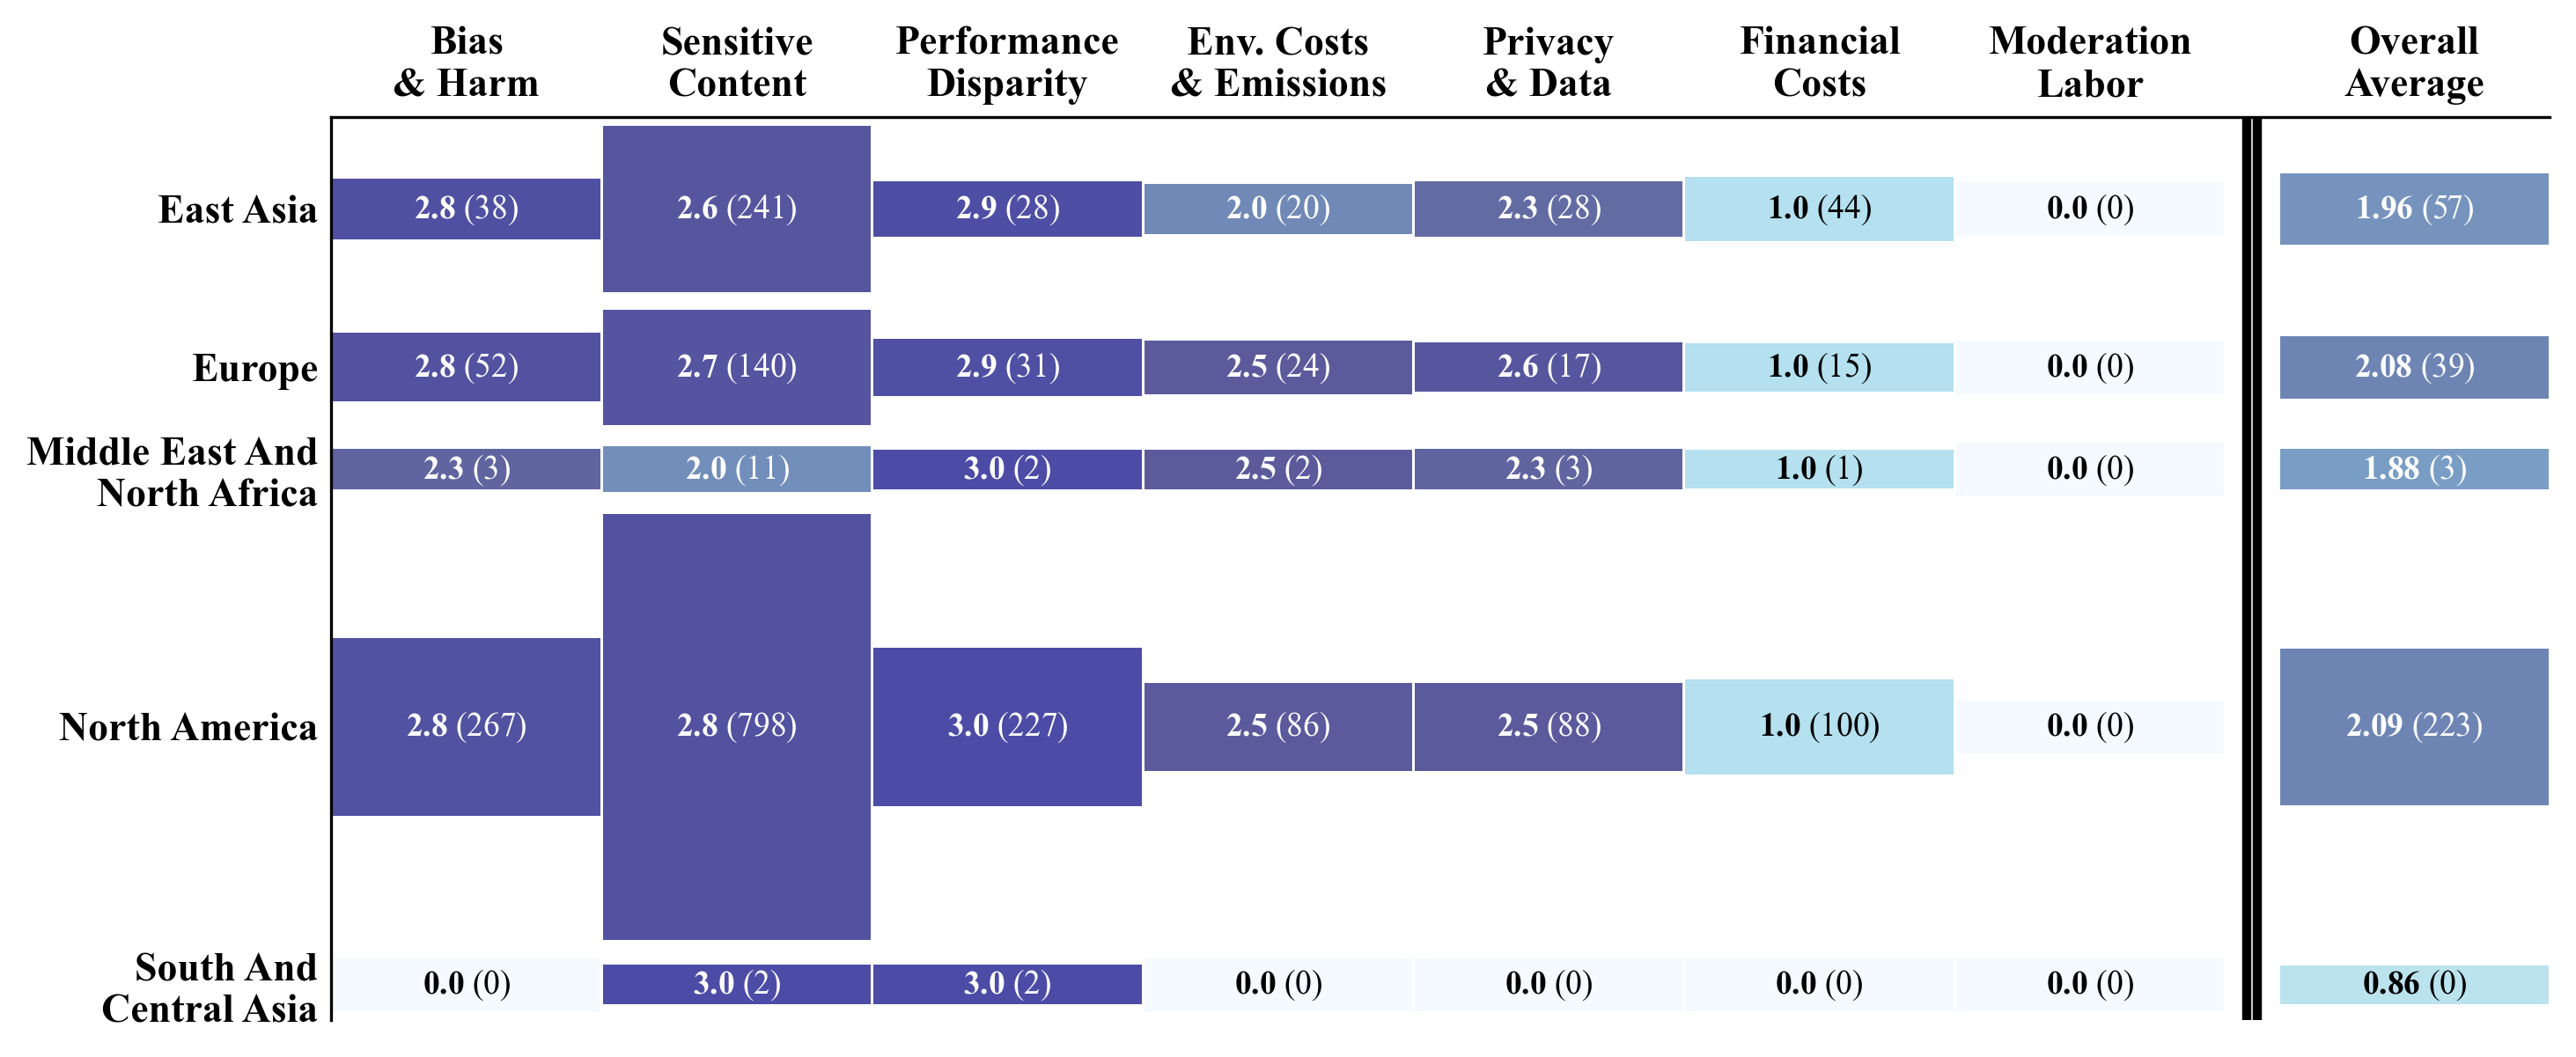

In [ ]:
fig = create_rectangle_plot('region',
                           fig_width=10,
                           fig_height=4.5,
                        #    row_gap=0.65,
                           min_rect_height=0.11,
                           max_rect_height=1.2,
                           rect_width=0.99,
                           power_scale=0.93,
                            row_gap=0.05,
                            separator_gap = 0.2,
                            show_rect_borders=False,
                            show_empty_cells=True,
                           show_quality_scores=True)
plt.savefig("evaluations_by_region.pdf", bbox_inches="tight")
plt.show()

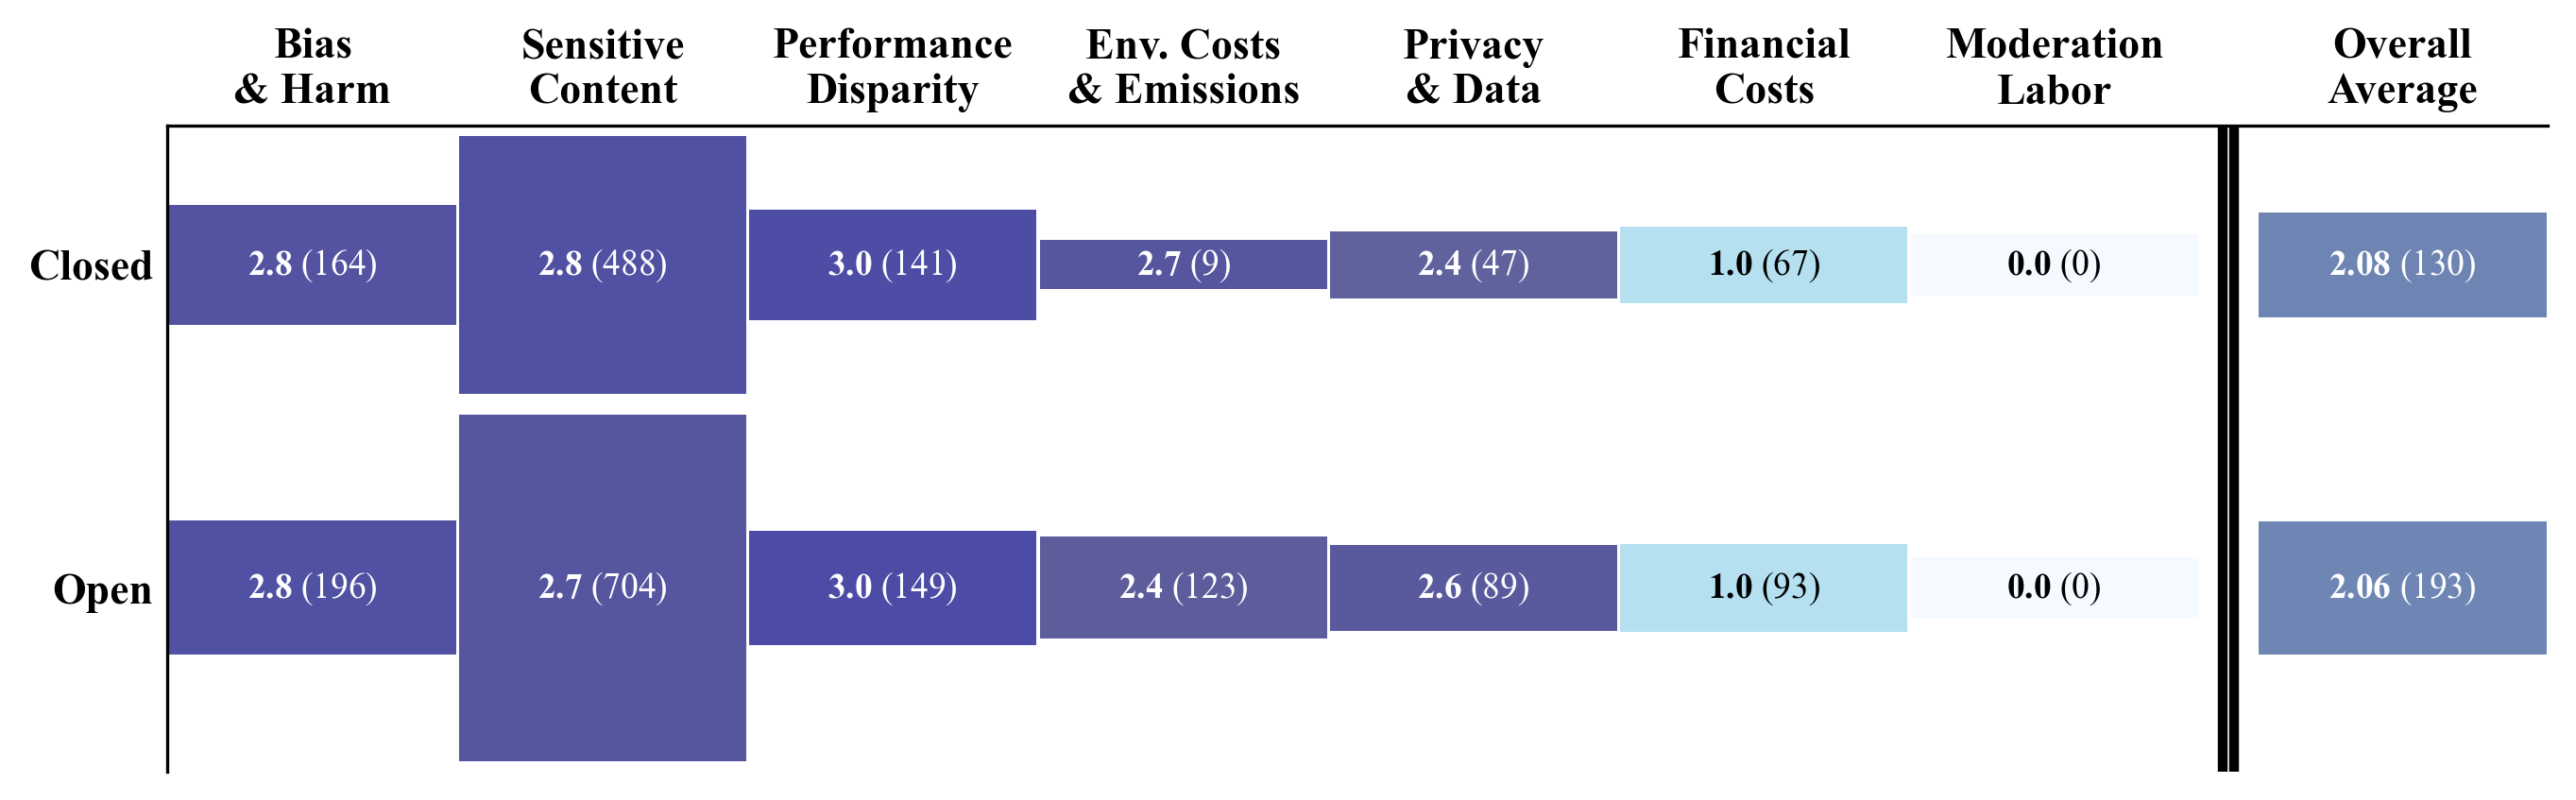

In [ ]:
fig = create_rectangle_plot('openness',
                           fig_width=10,
                           fig_height=3,
                        #    row_gap=0.8,
                           min_rect_height=0.11,
                           max_rect_height=0.85,
                           rect_width=0.99,
                           power_scale=0.95,
                           row_gap=0.05,
                            separator_gap = 0.2,
                            show_rect_borders=False,
                            show_empty_cells=True,
                           show_quality_scores=True)

plt.savefig("evaluations_by_openness.pdf", bbox_inches="tight")
plt.show()

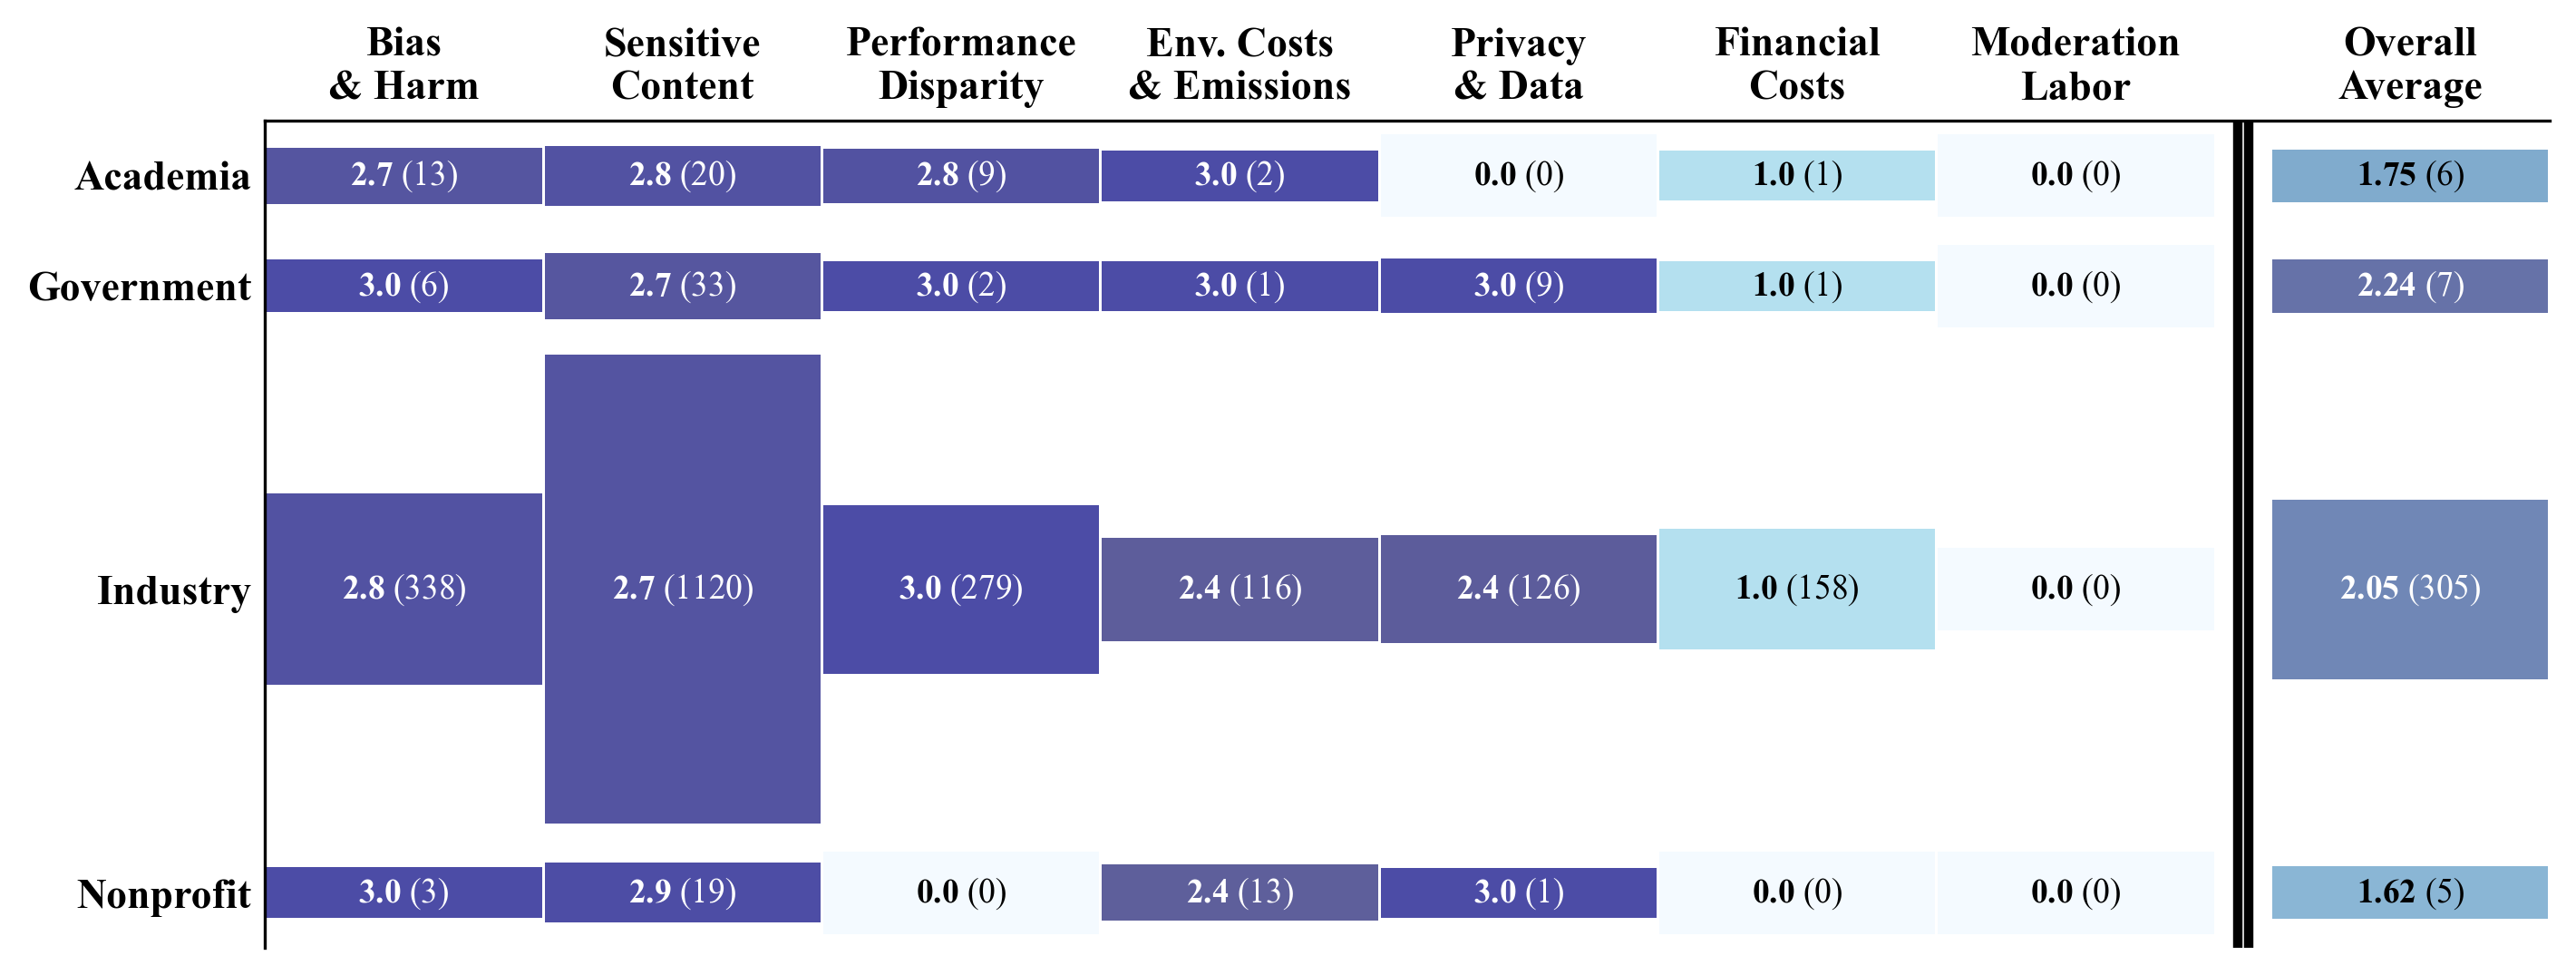

In [ ]:
fig = create_rectangle_plot('sector',
                           fig_width=10,
                           fig_height=4,
                        #    row_gap=0.5,
                           min_rect_height=0.09,
                           max_rect_height=0.85,
                           rect_width=0.99,
                           power_scale=0.9,
                           row_gap=0.05,
                            separator_gap = 0.2,
                            show_rect_borders=False,
                            show_empty_cells=True,
                           show_quality_scores=True)

plt.savefig("evaluations_by_sector.pdf", bbox_inches="tight")
plt.show()

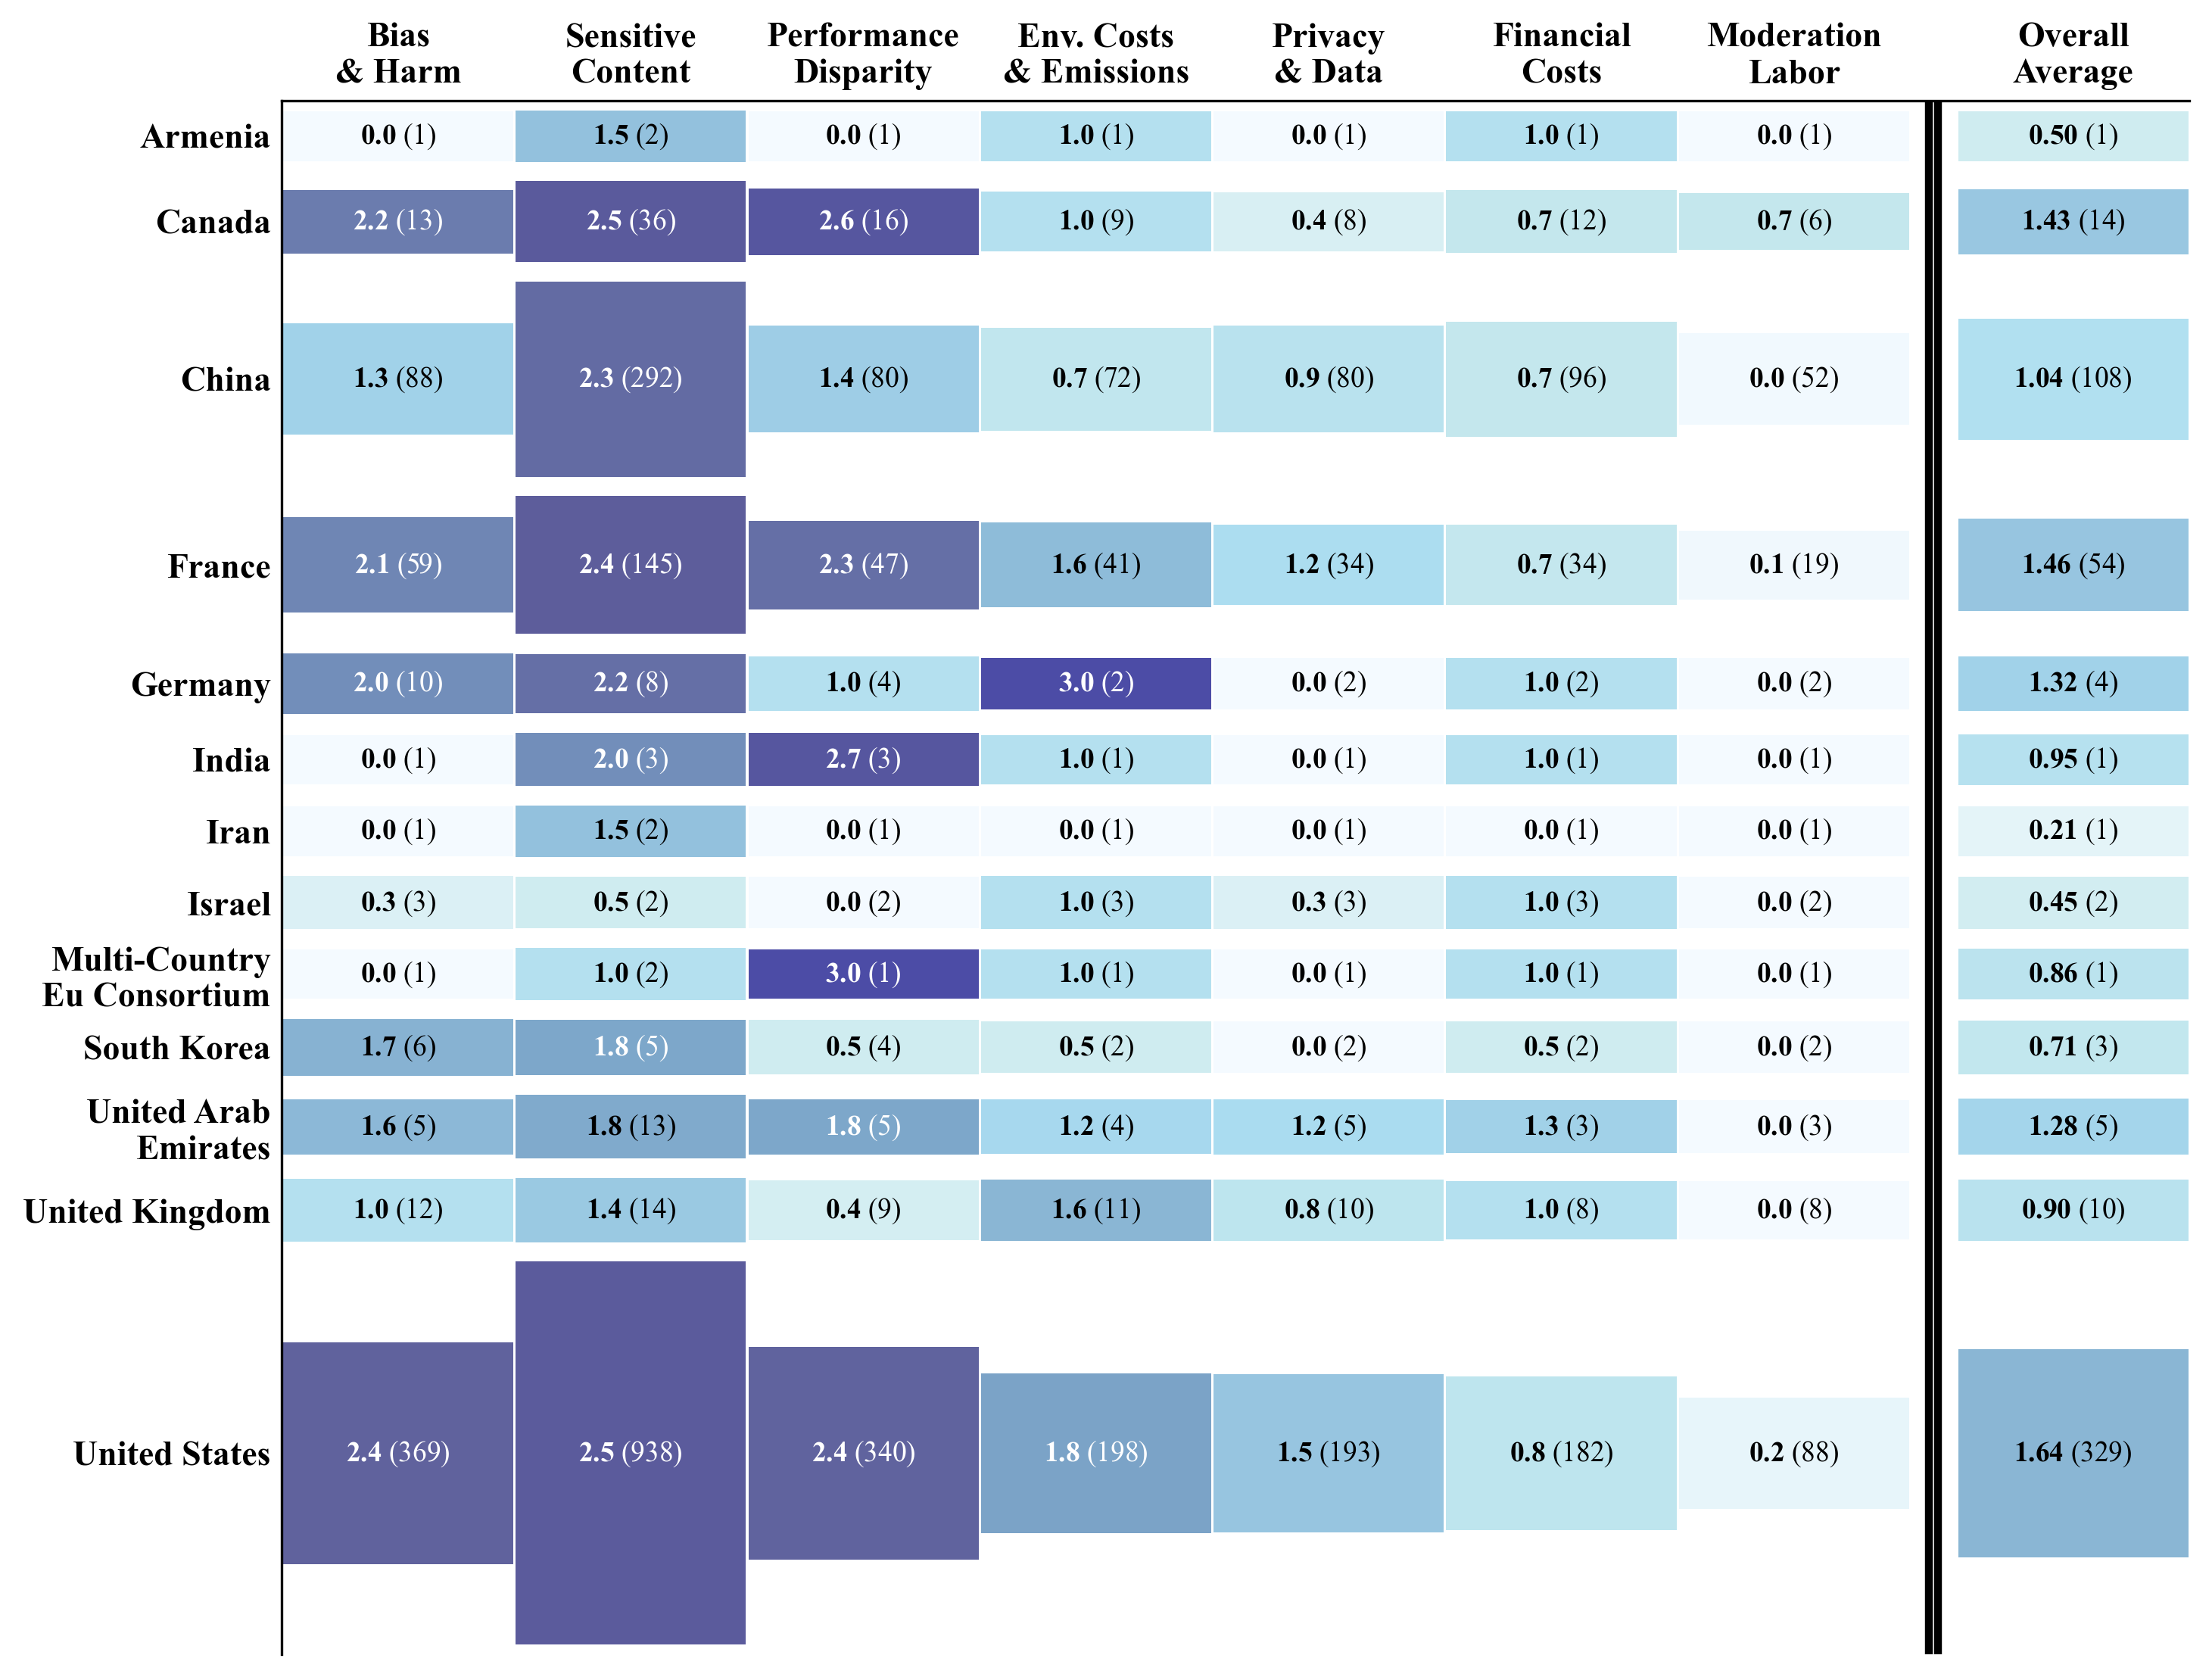

In [ ]:
fig = create_rectangle_plot('country',
                           fig_width=10,
                           fig_height=9,
                        #    row_gap=0.63,
                           min_rect_height=0.13,
                           max_rect_height=1.0,
                           rect_width=0.99,
                           power_scale=0.7,
                           row_gap=0.05,
                            separator_gap = 0.2,
                            show_rect_borders=False,
                            show_empty_cells=True,
                           show_quality_scores=True)

plt.savefig("evaluations_by_country.pdf", bbox_inches="tight")
plt.show()

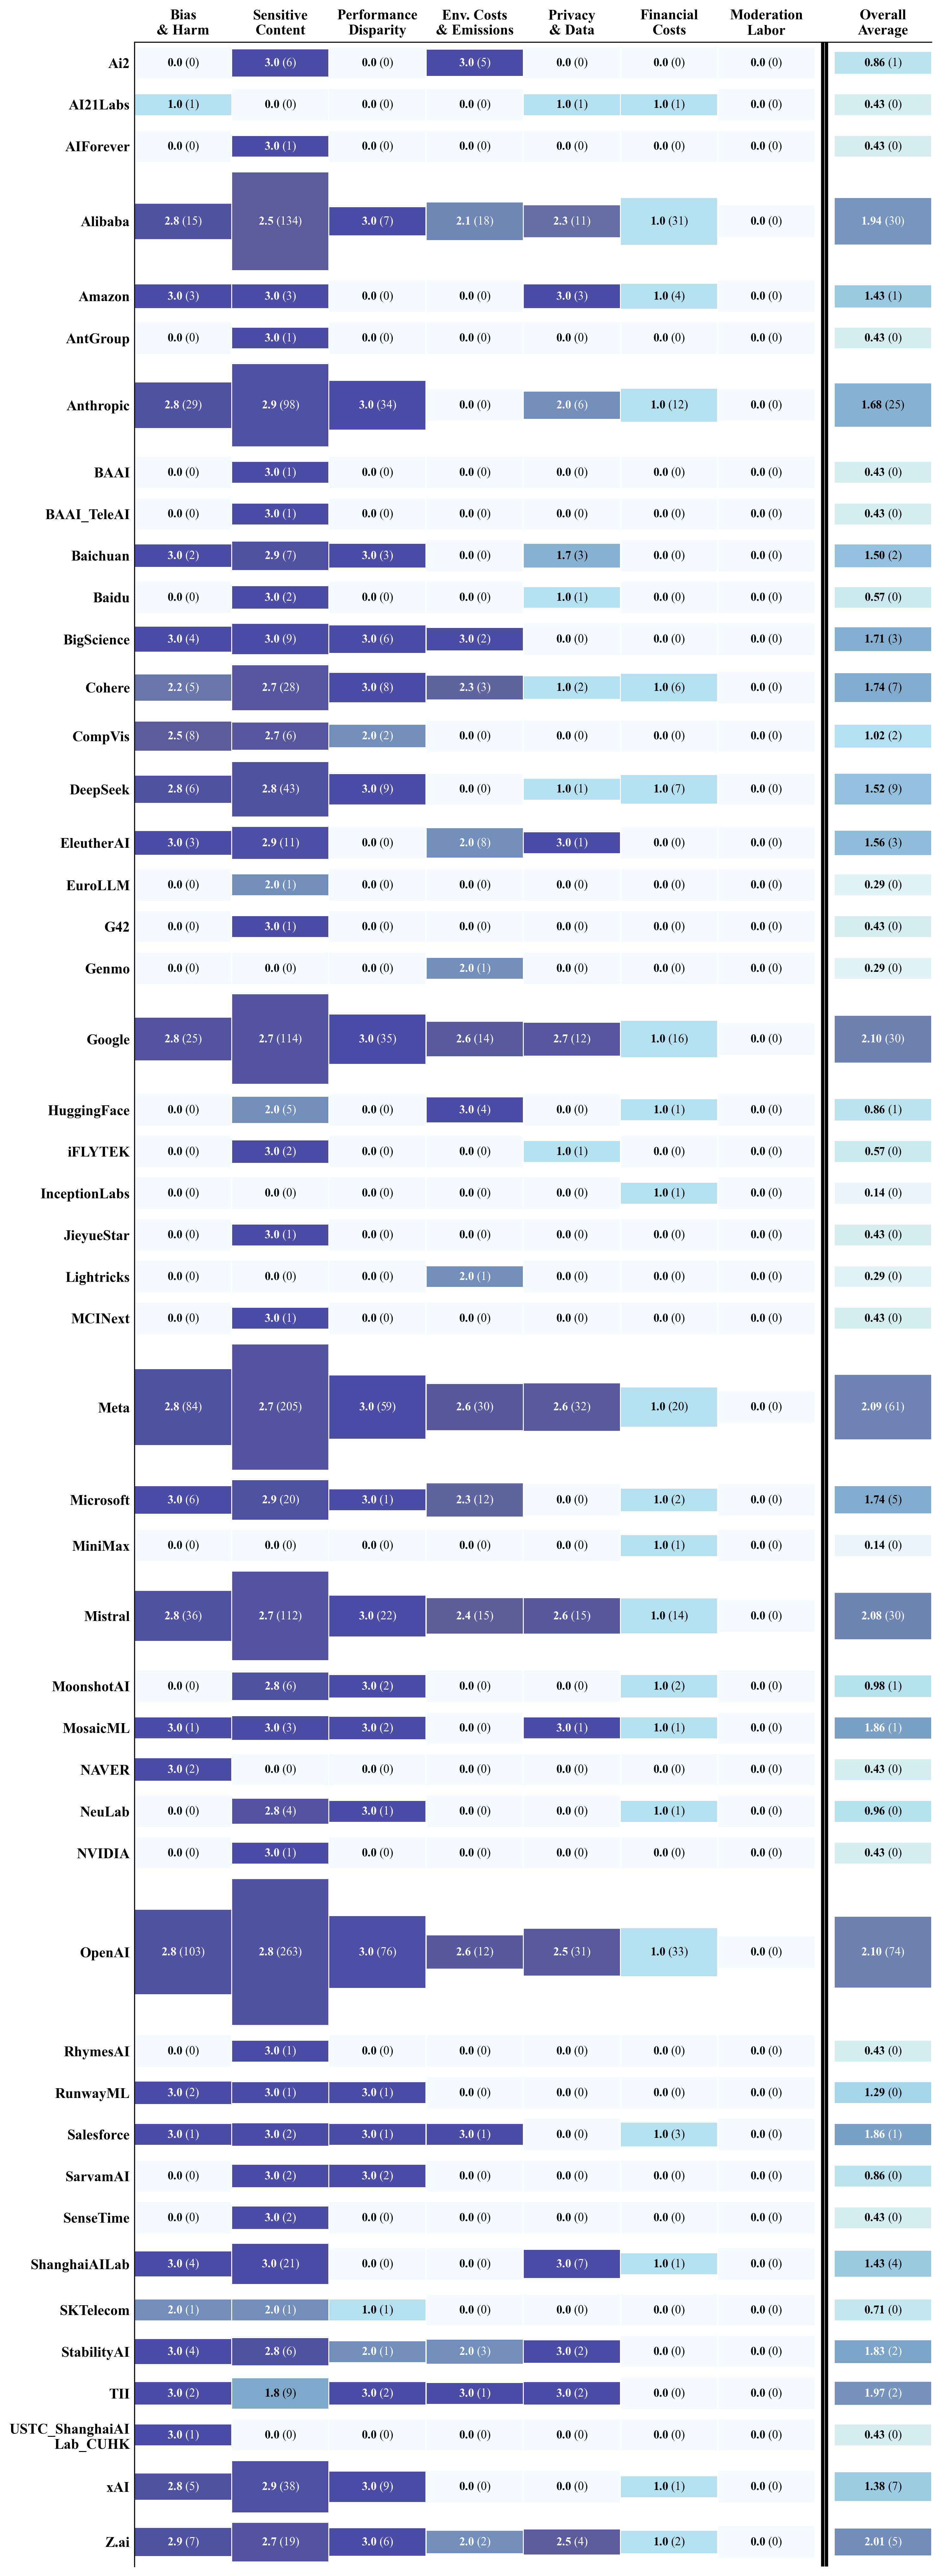

In [ ]:
fig = create_rectangle_plot('provider',
                           fig_width=10,
                           fig_height=35,
                        #    row_gap=0.45,
                           min_rect_height=0.1,
                           max_rect_height=0.7,
                           rect_width=0.99,
                           power_scale=0.7,
                           row_gap=0.05,
                            separator_gap = 0.2,
                            show_rect_borders=False,
                            show_empty_cells=True,
                           show_quality_scores=True)

plt.savefig("evaluations_by_provider.pdf", bbox_inches="tight")
plt.show()

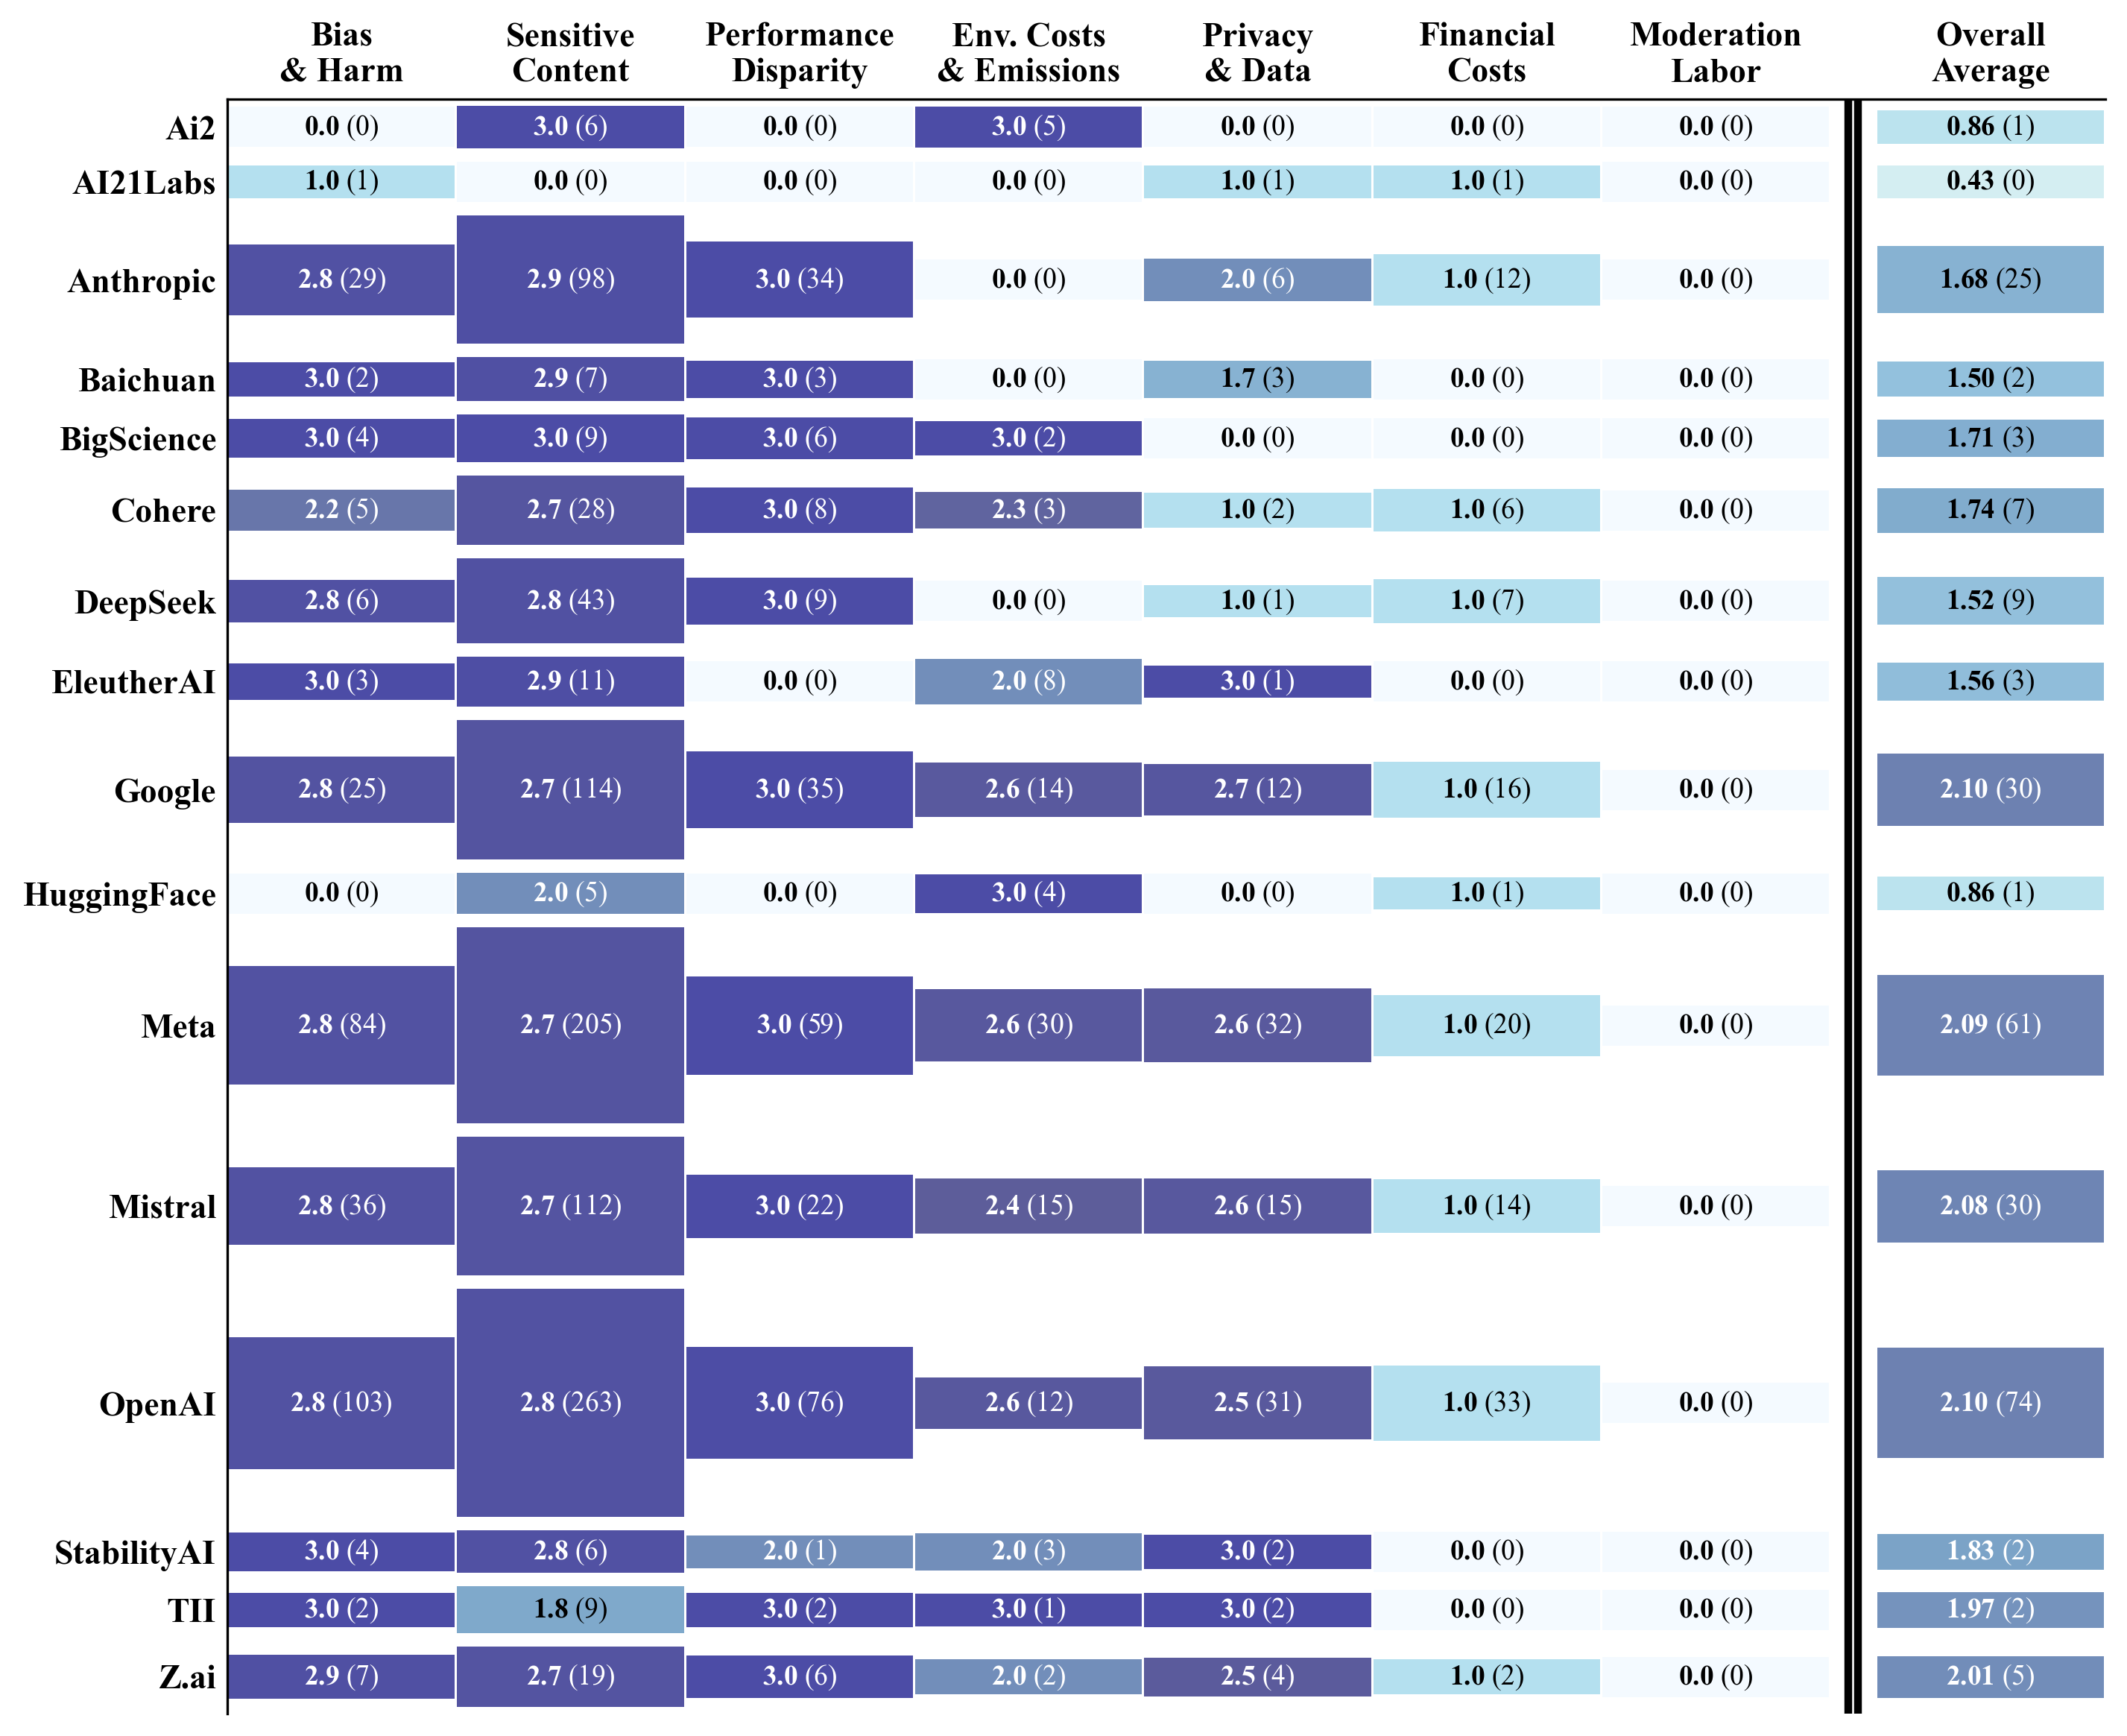

In [ ]:
companies = [
    "Ai2", "AI21Labs", "Anthropic", "Baichuan", "BigScience",
    "Cohere", "DeepSeek", "EleutherAI", "Google", "HuggingFace",
    "Meta", "Mistral", "OpenAI", "StabilityAI", "TII", "Z.ai"
]


fig = create_rectangle_plot('provider',
                           fig_width=10,
                           fig_height=9.5,
                        #    row_gap=0.7,
                           min_rect_height=0.12,
                           max_rect_height=0.85,
                           rect_width=0.99,
                           power_scale=0.7,
                           provider_list=companies,
                           row_gap=0.05,
                            separator_gap = 0.2,
                            show_rect_borders=False,
                            show_empty_cells=True,
                           show_quality_scores=True)

plt.savefig("evaluations_by_provider_selected.pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Debug code to check what's happening with the data
# Add this right after the plot_data is created in your main function

# Load and process data the same way as in the function
data_df = pd.read_csv("MAIN_ANNOTATIONS_MERGED.tsv", sep="\t")
data_df.columns = [c.strip() for c in data_df.columns]

df_clean = data_df.copy()
df_clean["category"] = pd.to_numeric(df_clean["category"], errors="coerce").astype("Int64")
df_clean["score"] = pd.to_numeric(df_clean["score"], errors="coerce")

df_clean = df_clean[
    df_clean["category"].isin(range(1, 8)) &
    df_clean["score"].between(0, 3, inclusive="both") &
    df_clean["region"].notna()
].copy()

# Aggregate data
model_cat = (
    df_clean.groupby(["provider", "name", "category", "region"], dropna=True)
    .agg(model_eval_count=("score", "size"),
         model_avg_score=("score", "mean"))
    .reset_index()
)

# Final aggregation by region and category
prov_cat_counts = (
    model_cat.groupby(["region", "category"], dropna=True)["model_eval_count"]
    .sum().rename("count").reset_index()
)

print("Top 10 region-category combinations by count:")
top_counts = prov_cat_counts.nlargest(10, 'count')
print(top_counts)

print(f"\nMaximum count value: {prov_cat_counts['count'].max()}")
print(f"Minimum count value: {prov_cat_counts['count'].min()}")

# Check which one has the maximum count
max_count_row = prov_cat_counts.loc[prov_cat_counts['count'].idxmax()]
print(f"\nHighest count is: {max_count_row['region']} x Category {max_count_row['category']} = {max_count_row['count']} evaluations")

# Check North America x Sensitive Content specifically
na_sensitive = prov_cat_counts[(prov_cat_counts['region'] == 'North America') & (prov_cat_counts['category'] == 2)]
if not na_sensitive.empty:
    print(f"North America x Sensitive Content: {na_sensitive['count'].iloc[0]} evaluations")
else:
    print("North America x Sensitive Content: No data found")

Top 10 region-category combinations by count:
           region  category  count
22  North America         2    967
21  North America         1    370
23  North America         3    343
1       East Asia         2    297
24  North America         4    194
25  North America         5    189
26  North America         6    182
8          Europe         2    170
5       East Asia         6     97
0       East Asia         1     93

Maximum count value: 967
Minimum count value: 1

Highest count is: North America x Category 2 = 967 evaluations
North America x Sensitive Content: 967 evaluations
